## load libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys, shutil
from os.path import abspath, dirname, basename
from glob import glob
import numpy as np
import pandas as pd
import warnings
import joblib
from tqdm import tqdm

In [3]:
# import toybrains
TOUYBRAINS_REPO = os.path.abspath("../../")
if TOUYBRAINS_REPO not in sys.path: sys.path.append(TOUYBRAINS_REPO)

from utils.DLutils import *
from utils.vizutils import *

In [4]:
DEEPREPVIZ_BACKEND = abspath( "../../../Deep-confound-control-v2/application/backend/deep_confound_control/core/")
assert os.path.isdir(DEEPREPVIZ_BACKEND) and os.path.exists(DEEPREPVIZ_BACKEND+'/DeepRepVizBackend.py'), f"No DeepRepViz repository found in {DEEPREPVIZ_BACKEND}. Add the correct relative path to the backend to the 'DEEPREPVIZ_BACKEND' global variable."
if DEEPREPVIZ_BACKEND not in sys.path:
    sys.path.append(DEEPREPVIZ_BACKEND)
from DeepRepVizBackend import DeepRepVizBackend

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Compute DL-act-based $A_{conf}$ scores

```bash
! python3 run-deeprepvizbackend.py
```
with correct configurations set inside the `run-deeprepvizbackend.py` file

### See log scores in a table

In [ ]:
# parallelize the loading of the logs
def process_drvlogdir(deeprepvizlogdir, verbose=1):
    if verbose==1: print("loading from:", deeprepvizlogdir)

    iter_version = basename(dirname(deeprepvizlogdir))
    if verbose==1: print("loading run version:", iter_version)
    # ignore the missing conf_table warning from DeepRepVizBackend
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Provided conf_table")
        drv_backend = DeepRepVizBackend(best_ckpt_by='loss_test')
    drv_backend.load_log(deeprepvizlogdir)

    log = drv_backend.deeprepvizlogs[deeprepvizlogdir]
    ckpt_idx = log['best_ckpt_idx']
    ckptname, log_ckpt = log['checkpoints'][ckpt_idx]
    logdirname = deeprepvizlogdir.split('/')[-3]
    dataset = logdirname.split('_')[3]
    model_name = logdirname.replace(dataset, '').split('__')[-1]
    if verbose==2:
        print(f"{'='*100}\n {model_name} :: \n\t setting: {dataset} ")
        print(f"\t at ckpt: {ckptname} (idx={ckpt_idx}) \n\t ckpt contains: {list(log_ckpt.keys())}")
        print("\t Model accuracy : {}".format({k:f'{v*100:.2f}%' for k,v in log_ckpt['metrics'].items()}))
        
    result = {("Model",k): v for k,v in log_ckpt['metrics'].items()}
    if 'act_metrics' not in log_ckpt:
        print(f"[ERROR] Metrics not computed for {logdirname}/{iter_version} at ckpt={ckptname} (idx={ckpt_idx}). Skipping...")
        
    else:
        for metric_name, metric_scores in log_ckpt['act_metrics'].items():
            if verbose==2: print(f"\t {'-'*10} \t Metric = {metric_name} \t {'-'*30}")
            for key in ['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']:
                if verbose: print("\t {} \t=\t {:.4f}".format(key, metric_scores[key]))
                result.update({(key, metric_name): metric_scores[key]})

    return (dataset, model_name, iter_version), result, drv_backend

In [5]:
# collect the DeepRepViz backend results in a dict
def collect_deeprepviz_results(logdirs, verbose=1, n_jobs=-1):

    # for each logdir extract the list of all runs
    logdirs_runs = []
    for logdir in logdirs:
        logdirs_runs.extend(sorted(glob(f"{logdir}/*/deeprepvizlog")))

    all_results_drvs = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(process_drvlogdir)(drvlogdir, verbose) for drvlogdir in tqdm(logdirs_runs))
    
    if len(all_results_drvs)==0:
        print("[ERROR] No results were loaded. Exiting...")
        return None
    
    all_results = {keys: results for keys, results, _ in all_results_drvs}
    
    df_results = pd.DataFrame.from_dict(all_results, orient='index')
    df_results.index = df_results.index.set_names(['dataset', 'model_name', 'trial'])
    # first sort by model name, then by data setting and finally by trial
    df_results = df_results.sort_index(level='trial').sort_index(level='dataset',
                                       key=lambda x: x.str[-3:].astype(int)*10 + (x.str[2:5].astype(int) * x.str[8:11].astype(int))/2)
    # sort the columns by model name and then by metric name
    df_results = df_results.sort_index(axis=1, level=[0,1])
    
    return df_results


In [6]:
# select the model runs for which we want to compare the results
cy = '*'
cX = '*'
yX = '*'
logdirs = sorted(
    list(set([
        (dirname(dirname(log))) for log in glob(f"log/toybrains*_cy{cy}-cX{cX}-yX{yX}*/*/deeprepvizlog") if 'debug' not in log]
        )))

print("Collected n={} model logs:".format(len(logdirs)))

# drop log folders that are not complete
logdirs = [logdir for logdir in logdirs if len(glob(f"{logdir}/*/deeprepvizlog/DeepRepViz-v1*"))==len(glob(f"{logdir}/*/deeprepvizlog/"))]
print("after dropping incomplete logs n={} logs are still remaining".format(len(logdirs)))
logdirs

Collected n=75 model logs:
after dropping incomplete logs n=75 logs are still remaining


['log/toybrains_n10000_lblmidr-consite_cy0-cX2-yX0_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX2-yX1_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX2-yX2_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX2-yX3_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX2-yX4_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX3-yX0_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX3-yX1_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX3-yX2_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX3-yX3_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX3-yX4_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX4-yX0_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX4-yX1_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX4-yX2_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX4-yX3_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-con

In [7]:
df_results = collect_deeprepviz_results(logdirs, print_log=0)
print("loaded {} rows with {} models, {} unique datasets per model & {} trials per dataset.".format(len(df_results), 
                                            (df_results.index.get_level_values('model_name').nunique()), 
                                            (df_results.index.get_level_values('dataset').nunique()), 
                                            (df_results.index.get_level_values('trial').nunique())))

  0%|          | 0/75 [00:00<?, ?it/s]

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested

loaded 375 rows with 1 models, 75 unique datasets per model & 5 trials per dataset.


In [23]:
# df_results.style.bar()

In [8]:
df_results.copy().groupby(['dataset', 'model_name'], sort=False).mean().style.bar() # show average values across trials

### Viz Model accuracies

In [9]:
# X_axes=['c->y', 'X->y']
# col = 'model_name'
# metric_col='BAC_test'
# err_style='bars'
# y_label_suffix = ''

# # only select model results on test data
# df_results_fil = df_results.xs('BAC_test', level=1, axis=1)

# df = df_results_fil.copy().reset_index()
# # shorten the 'dataset' name for the plot labels
# df['dataset'] = df['dataset'].apply(lambda x: x.split('_')[-1])

# # get the iterations of yX, cX, and cy as separate columns
# df[['c->y','c->X','X->y']] = df['dataset'].str.split('-', expand=True)
# for col in ['X->y','c->X','c->y']:
#     # print(col, df[col].values[0])
#     df[col] = df[col].str[-1].astype(int)

# # rename the test_metric column to 'Model pred. contrib score'
# y=f'Model-based contrib score {y_label_suffix}'
# df = df.rename(columns={metric_col:y})


# col_order = df[col].unique()

# # display(df)
# for x in X_axes:
#     if x=='X->y':
#         hue='c->X'
#         size='c->y'
#     elif x=='c->X':
#         hue='X->y'
#         size='c->y'
#     elif x=='c->y':
#         hue='X->y'
#         size='c->X'
#     else:
#         assert False, f"invalid col {x}"

#     sns.set(style="darkgrid")
#     g = sns.relplot(data=df, kind='line', 
#             x=x,y=y, hue=hue, style=size, size=size,
#             err_style=err_style,
#             # hue='inp', height=30, aspect=0.5,
#             col_wrap=2, col=col, palette='brg_r',
#             col_order=col_order,
#             height=5, aspect=1.5,
#         )
#     # turn on frame of the legend
#     g._legend.set_frame_on(True)
#     # set y lim to 0-100
#     # g.set(ylim=(0, 100))
#     g.fig.suptitle(f"{y} as we iteratively increase {x}", fontsize=20)
#     g.fig.subplots_adjust(top=0.9)
#     plt.show()

### Viz act-based scores

In [10]:
def plot_deeprepviz_results(df_results, 
                            filter = '',
                            norm_metrics = '', #'dcor|mi|con|r2',
                            ylim = None):
    # drop the indexes 'model_name' and 'trial' and only keep the 'data_setting' as index
    df = df_results.copy().reset_index(level=['model_name', 'trial'])
    for feas, dfi in df.groupby('model_name'):
        # drop the loss
        loss_cols = dfi.columns[dfi.columns.get_level_values(1).str.contains('loss')].values.tolist() 

        dfi = dfi.drop(columns=[('model_name', ''),('trial', ''), *loss_cols])
        # flatten the multi-index columns
        dfi.columns = [' | '.join(col[::-1]).strip() for col in dfi.columns.values]
        # drop the costeta columns and additional user-defined filters
        dfi = dfi.filter(regex='^(?!.*costeta)')
        # sort the index by 10*(X<-y) + (X<-c * c->y)/2
        dfi = dfi.sort_index(key=lambda x: x.str[-1].astype(int)*10 + (x.str[2].astype(int) * x.str[6].astype(int))/2)
    
        # sort the columns alphabetically
        dfi = dfi.reindex(sorted(dfi.columns), axis=1)
        
        # normalize the metrics requested
        if norm_metrics != '':
            metric_cols = dfi.columns.str.contains(norm_metrics)
            dfi.loc[:, metric_cols] = dfi.loc[:, metric_cols].apply(
            lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=1)
    
        # apply 
        if filter != '':
            dfi = dfi.filter(regex=filter)
        assert dfi.shape[0] > 0, f"No columns remained after applying the filter: {filter}"

        # plot the results
        fig, ax = plt.subplots(figsize=(16, 6))
        g = sns.lineplot(dfi, err_style="bars", ax=ax)
        sns.move_legend(g, loc="upper center", bbox_to_anchor=(0.5, 1.5), ncols=4)
        
        ax.set_title(f"DL model settings: {feas.split('_')}")
        if ylim is not None or norm_metrics!='':
            ax.set_ylim(ylim)

        # on the x-axis ticks show the total X<-y and the total X<-c->y
        new_xticklabels = []
        majorticks = [-1]
        last_Xy = -1
        last_Xcy = -1
        for lbl in ax.get_xticklabels():
            cy, cX, yX  = lbl.get_text().split('-')
            cy = int(cy[-1])
            cX = int(cX[-1])
            yX = int(yX[-1])
            total_Xy = 100*(yX)/4
            total_Xcy = 100*(cX*cy)/16
            # add a major tick label every time the total_Xy changes
            if total_Xcy - last_Xcy >= 95:
                majorticks.append(lbl.get_position()[0])

            if total_Xy != last_Xy:
                new_xticklabels.append(f'Xy={total_Xy:3.0f}%      {total_Xcy:3.0f}%')
                last_Xy = total_Xy
            else:
                new_xticklabels.append(f'{total_Xcy:3.0f}%')
        
        ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)
        # vertical lines to show transition of X<-c->y
        for x_line in majorticks:
            ax.axvline(x_line, color='grey', ls='--', lw=0.8, alpha=0.5)
            ax.vlines(x_line, 0, -0.25, color='grey', ls='--', lw=0.8,
                    clip_on=False,
                    transform=ax.get_xaxis_transform())
        # ax.set_xlim(-1, majorticks[-1]+1)
        ax.set_xlabel(r'Increasing confound signal [$X \leftarrow c \to y$]'+'\n'+r'   &   True signal  [$X \leftarrow y$] ', fontsize=15)
    
        plt.show()


Model performance 

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


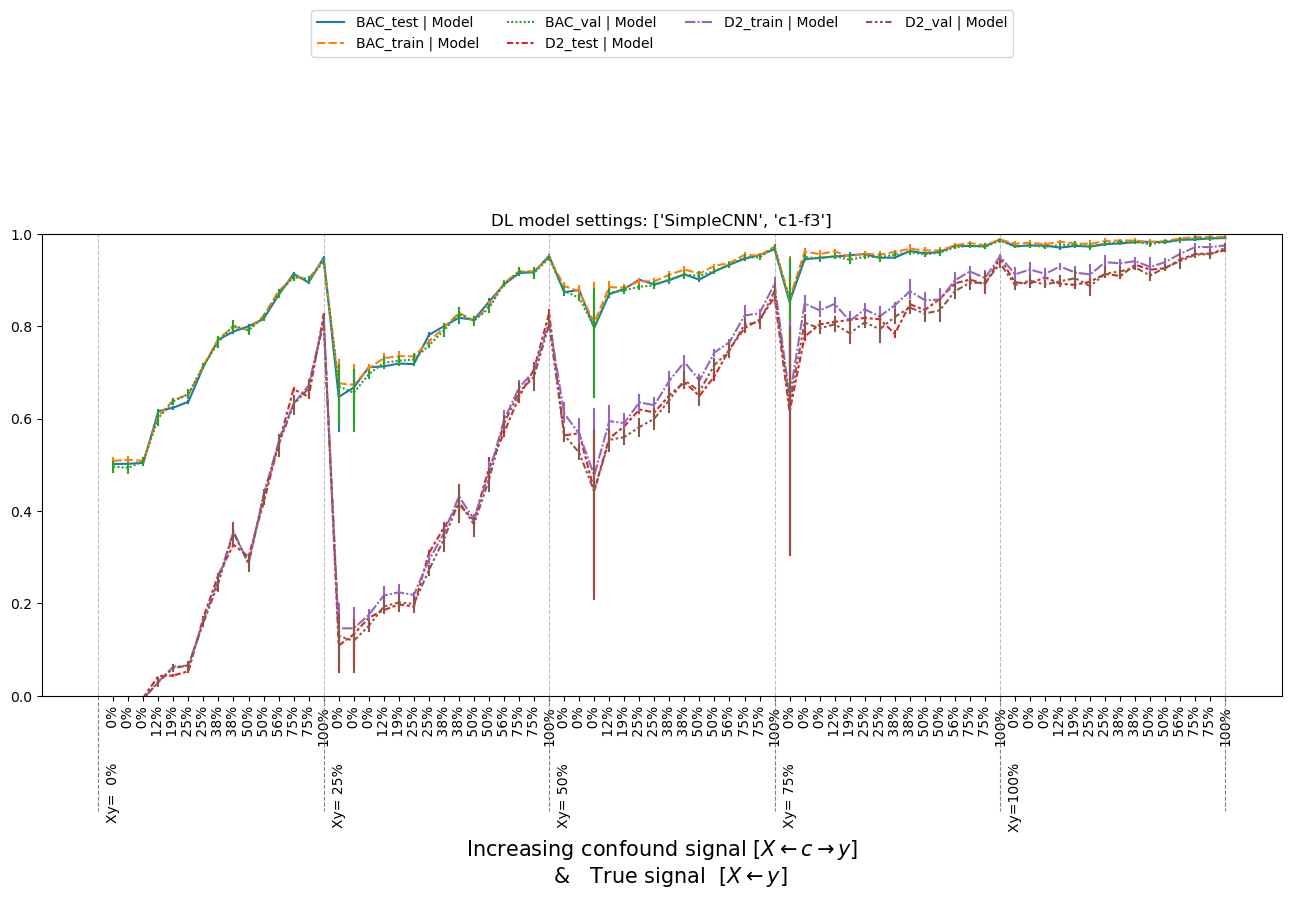

In [11]:
plot_deeprepviz_results(df_results, filter='Model.*', 
                        norm_metrics='', ylim=(0,1))

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


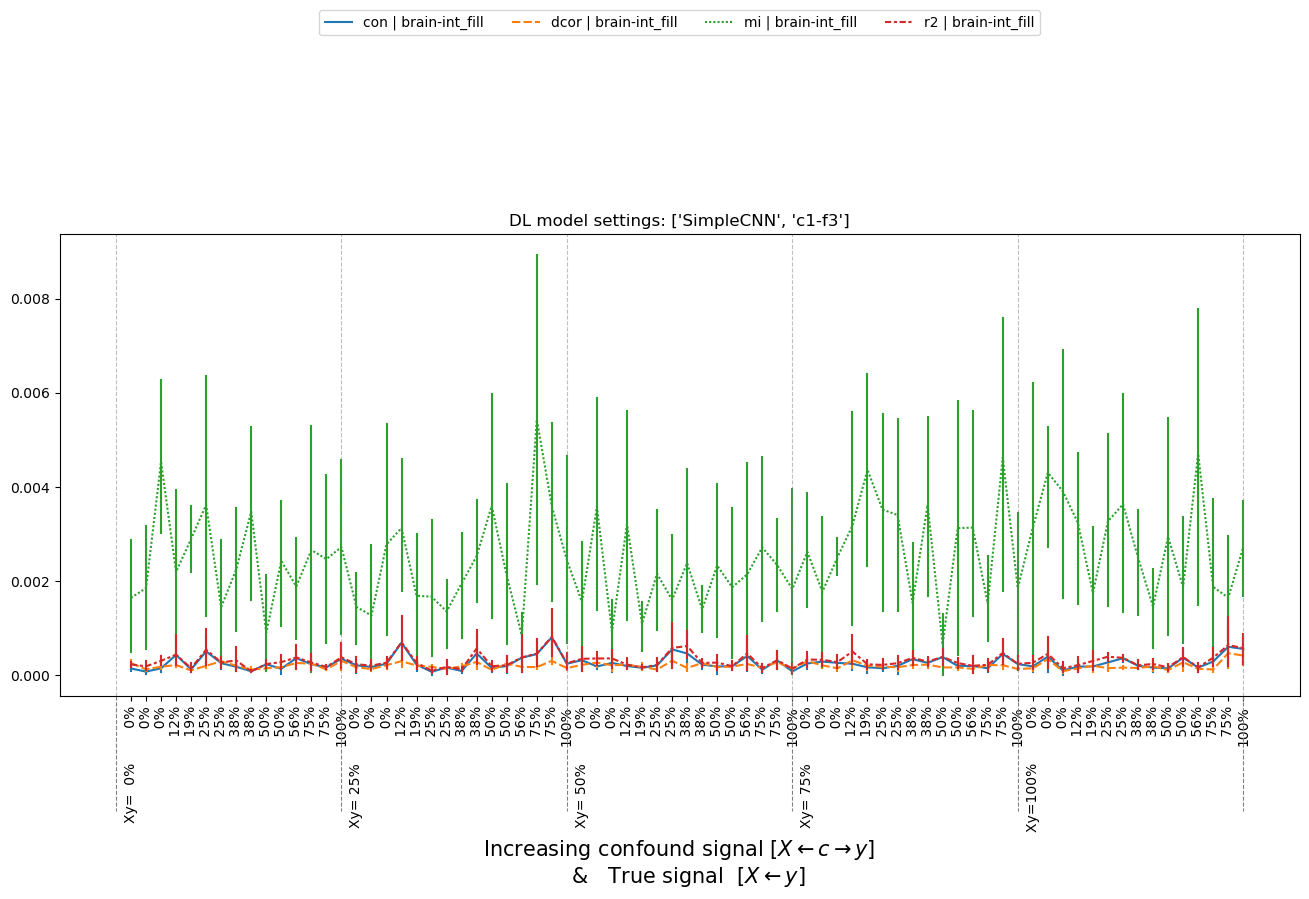

In [12]:
plot_deeprepviz_results(df_results, filter="(brain-int_fill)")

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


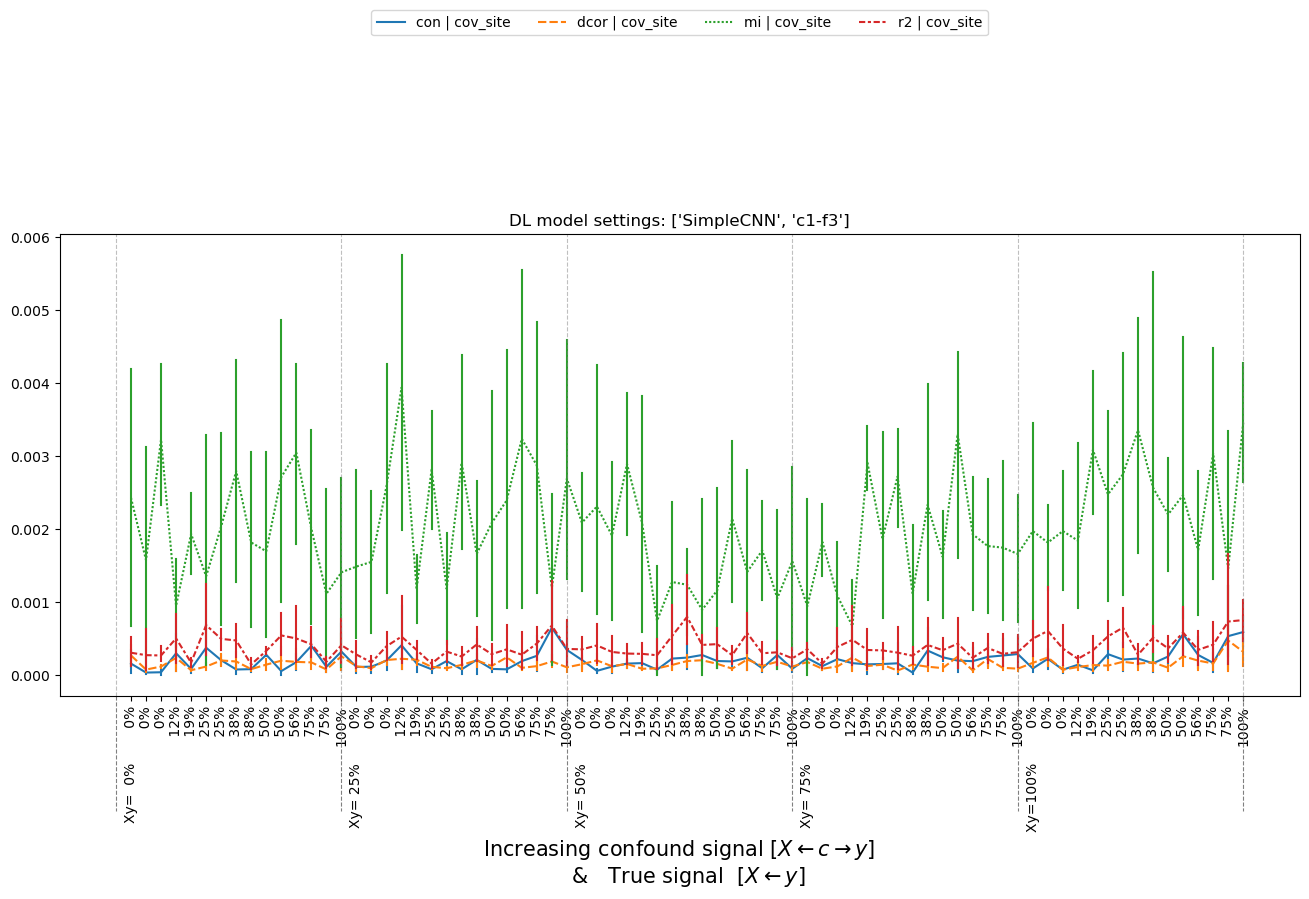

In [13]:
plot_deeprepviz_results(df_results, filter="(cov_site)")

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


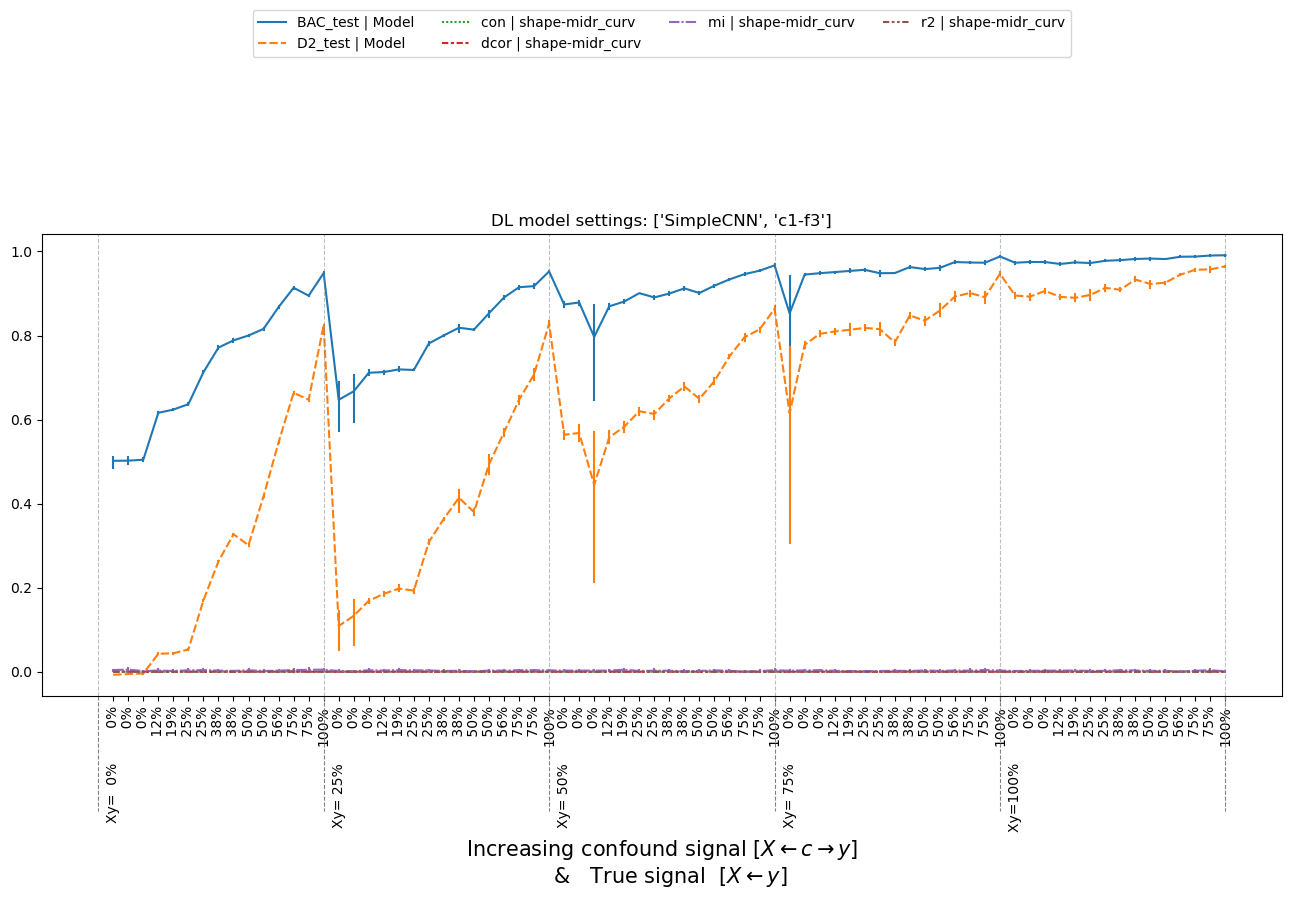

In [14]:
plot_deeprepviz_results(df_results, filter="(.*_test|shape-midr_curv)")

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


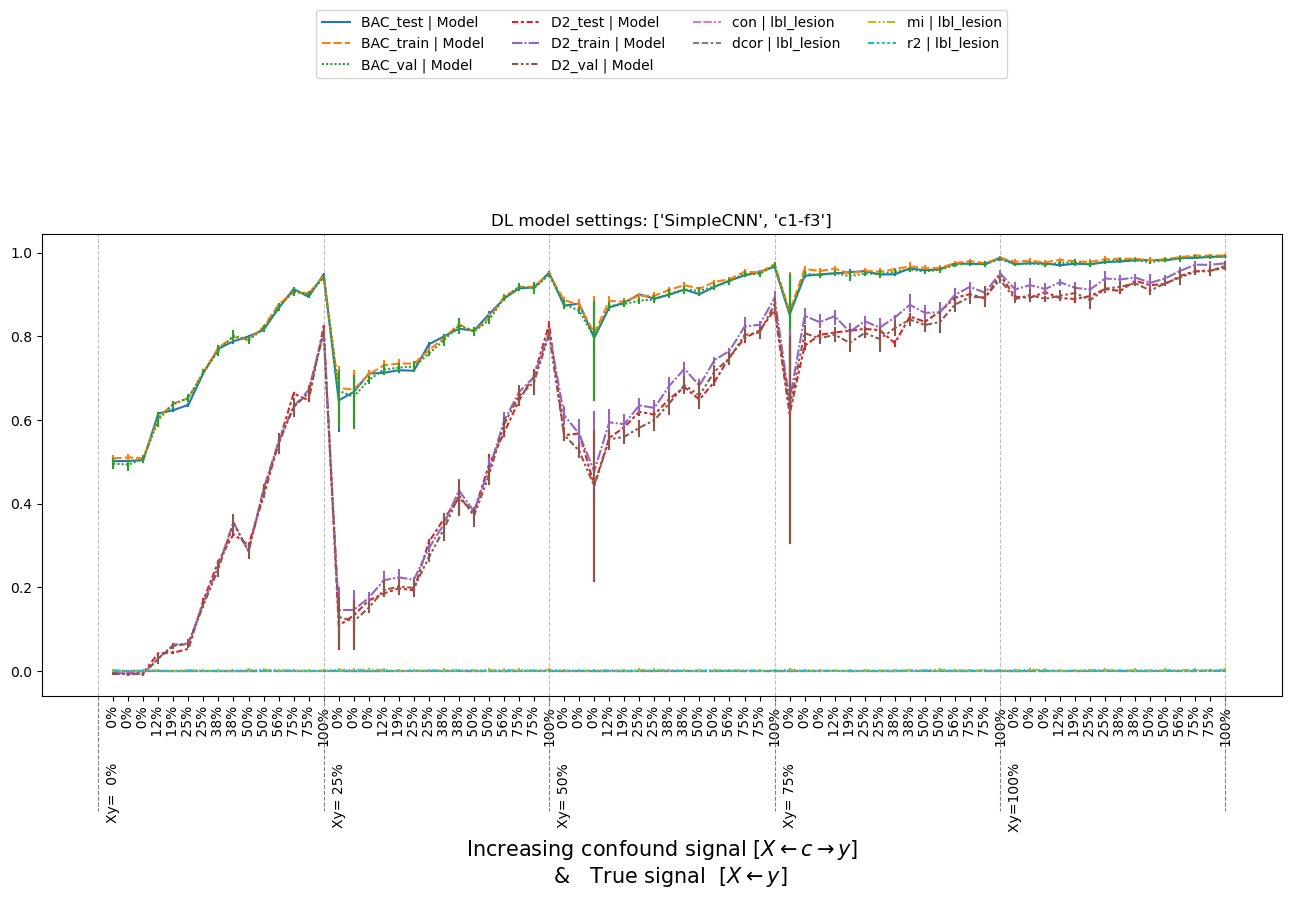

In [15]:
plot_deeprepviz_results(df_results, filter="(Model|lbl_lesion)")

In [16]:
# custom_filter = "Model|cov_site" #|lbl_lesion|cov_site|brain-int_fill 
# dfi = df_results.copy()

# # drop the loss
# dfi = dfi.drop(columns=[('Model', 'loss')])
# # flatten the multi-index columns
# dfi.columns = [' | '.join(col[::-1]).strip() for col in dfi.columns.values]
# # sort the columns alphabetically
# dfi = dfi.reindex(sorted(dfi.columns), axis=1)
# # drop the costeta columns
# dfi = dfi.filter(regex='^(?!.*costeta)')
# # apply additional user-defined filters
# dfi = dfi.filter(regex=custom_filter)
# dfi = dfi.reset_index(level=0).rename(columns={'level_0': 'DL model settings'})
# # display(dfi)

# # normalize the metric scores
# metric_cols = dfi.columns.str.contains('dcor|mi|con|r2')
# dfi.loc[:, metric_cols] = dfi.loc[:, metric_cols].apply(
#     lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=1)

# g = sns.FacetGrid(dfi, row='DL model settings',  margin_titles=True, 
#                   height=3, aspect=2)
# g.map_dataframe(sns.lineplot)
# g.add_legend()  
# # plt.tight_layout()
# plt.show()

### compare 2 model settings

In [17]:
cy = '*'
cX = 2
yX = 2
logdirs2 = sorted(
    list(set([
        (dirname(dirname(log))) for log in glob(f"log/toybrains*_cy{cy}-cX{cX}-yX{yX}*/*/deeprepvizlog") if 'debug' not in log]
        )))

print("comparing results from n={} model logs:".format(len(logdirs2)))
logdirs2

comparing results from n=5 model logs:


['log/toybrains_n10000_lblmidr-consite_cy0-cX2-yX2_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy1-cX2-yX2_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy2-cX2-yX2_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy3-cX2-yX2_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy4-cX2-yX2_SimpleCNN_c1-f3']

In [18]:
df_results2 = collect_deeprepviz_results(logdirs2, print_log=1)
df_results2.style.bar()

  0%|          | 0/5 [00:00<?, ?it/s]

loading logs from: log/toybrains_n10000_lblmidr-consite_cy0-cX2-yX2_SimpleCNN_c1-f3
loading logs from: log/toybrains_n10000_lblmidr-consite_cy1-cX2-yX2_SimpleCNN_c1-f3
loading run version: trial_0
loading logs from: log/toybrains_n10000_lblmidr-consite_cy3-cX2-yX2_SimpleCNN_c1-f3
loading run version: trial_0
loading logs from: log/toybrains_n10000_lblmidr-consite_cy2-cX2-yX2_SimpleCNN_c1-f3
loading run version: trial_0
loading logs from: log/toybrains_n10000_lblmidr-consite_cy4-cX2-yX2_SimpleCNN_c1-f3
loading run version: trial_0
loading run version: trial_0
	 lbl_lesion 	=	 0.0000
	 cov_site 	=	 0.0001
	 brain-int_fill 	=	 0.0002
	 shape-midr_curv 	=	 0.0003
	 shape-midr_vol-rad 	=	 0.0002
	 lbl_lesion 	=	 0.0000
	 cov_site 	=	 0.0013
	 brain-int_fill 	=	 0.0031
	 shape-midr_curv 	=	 0.0000
	 shape-midr_vol-rad 	=	 0.0035
	 lbl_lesion 	=	 0.0003
	 cov_site 	=	 0.0007
	 brain-int_fill 	=	 0.0009
	 shape-midr_curv 	=	 0.0004
	 shape-midr_vol-rad 	=	 0.0003
	 lbl_lesion 	=	 -0.7741
	 cov

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


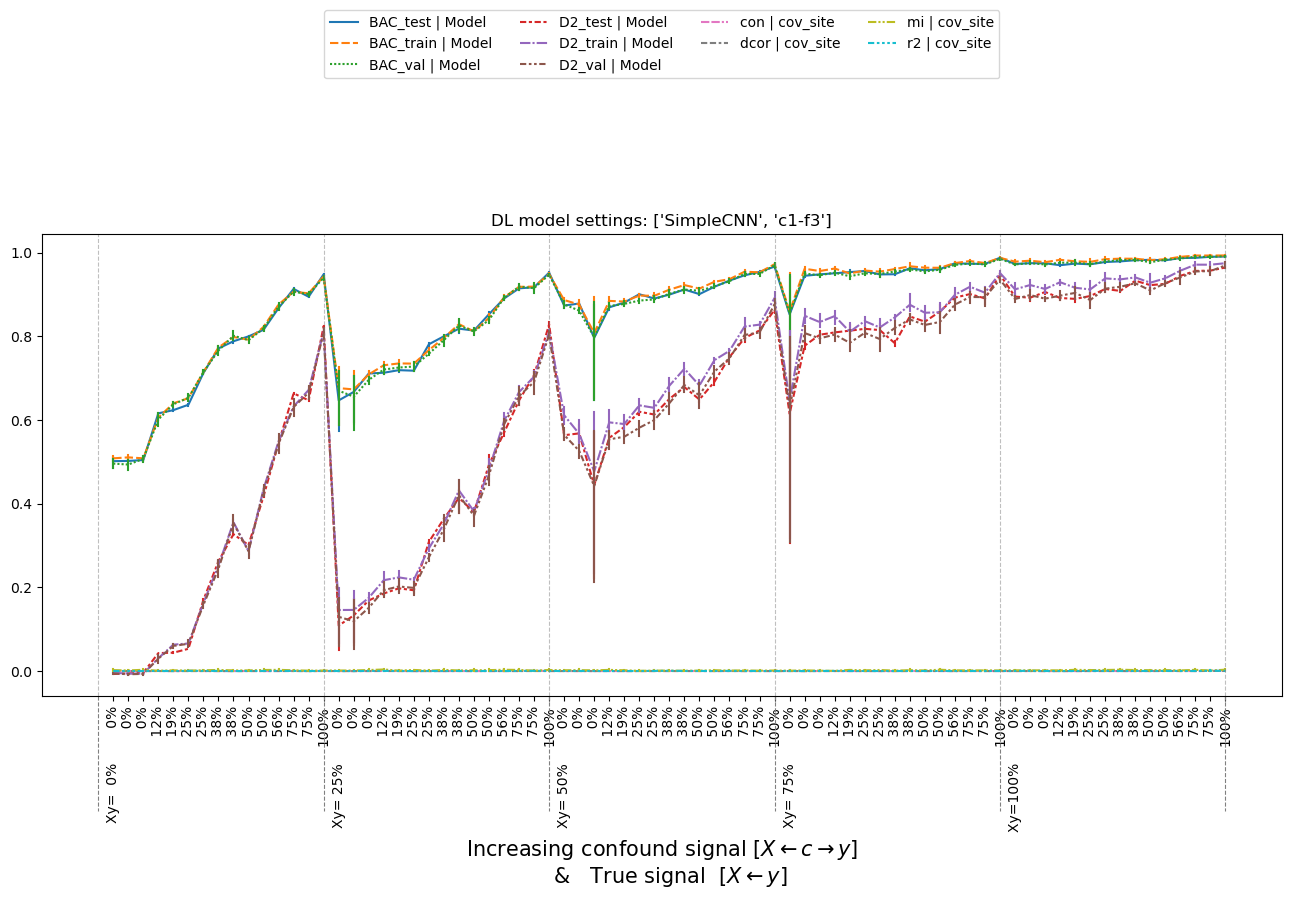

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


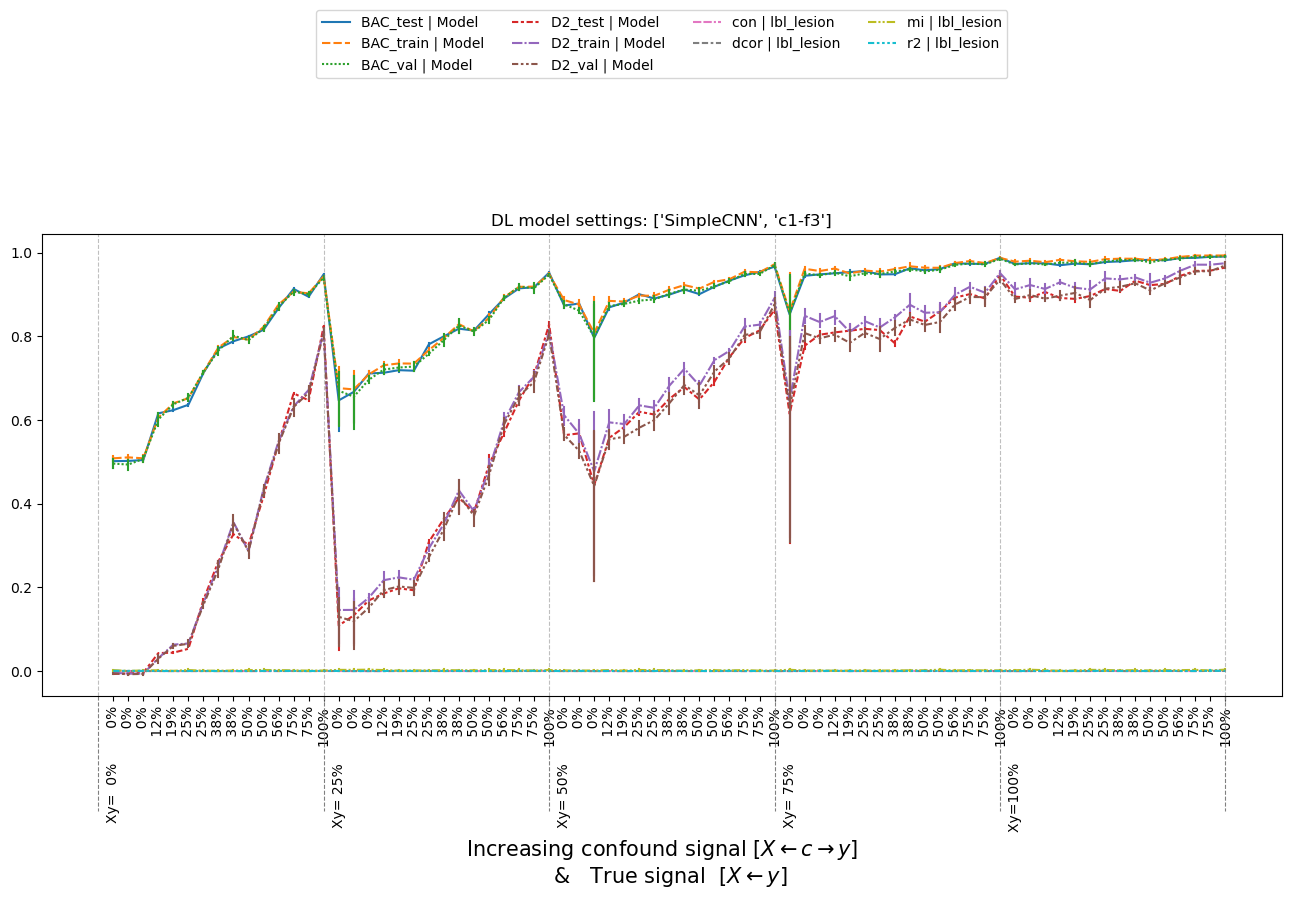

In [19]:
plot_deeprepviz_results(df_results, filter="(Model|cov_site)")
plot_deeprepviz_results(df_results, filter="(Model|lbl_lesion)")

#### test with a different 3D dimensionality reduction method?

In [20]:
# dim_reduct_method = TSNE(n_components=3, learning_rate='auto',
#                          init='random', perplexity=3) 

In [21]:
# %reload_ext tensorboard
# %tensorboard --logdir=./log/lightning_logs/
# !kill -9 1237900

#### Calculate other backend metrics ?